In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random
import warnings

# import keras
np.random.seed(1337)
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv1D

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'


def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='seq', seq_len=44):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

2024-01-09 16:57:54.663324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# e_train = pd.read_csv("../../data/VEE_5UTR_0429/VEE_0429_train.csv")
# e_test = pd.read_csv("../../data/VEE_5UTR_0429/VEE_0429_test.csv")
# df=pd.read_csv("../../data/VEE_5UTR_0611/VEE-0611.csv")
df=pd.read_csv("../../data/VEE_5UTR_0429/VEE-0429.csv")
plasmid_gate, rna_gate = 30,5
df=df[(df["rna_counts"]>rna_gate)&(df["plasmid_counts"]>plasmid_gate)]
e_train = df.sample(frac=0.8)
e_test= df[~df.index.isin(e_train.index)]
seq_e_train = one_hot_encode(e_train,seq_len=44)
seq_e_test = one_hot_encode(e_test, seq_len=44)

# Scale the training mean ribosome load values
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'score'].values.reshape(-1,1))

In [14]:
model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=5,border_mode='same',
                   inp_len=44, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)
e_test = test_data(df=e_test, model=model, obs_col='score',test_seq=seq_e_test)
r = r2(e_test['score'], e_test['pred'])
print('r-squared = ', r)

Epoch 1/5
69/69 [==============================] - 8s 103ms/step - loss: 0.6795
Epoch 2/5
69/69 [==============================] - 7s 107ms/step - loss: 0.3606
Epoch 3/5
69/69 [==============================] - 10s 139ms/step - loss: 0.3008
Epoch 4/5
69/69 [==============================] - 7s 102ms/step - loss: 0.2757
Epoch 5/5
69/69 [==============================] - 1s 10ms/step
r-squared =  0.7737372748765103


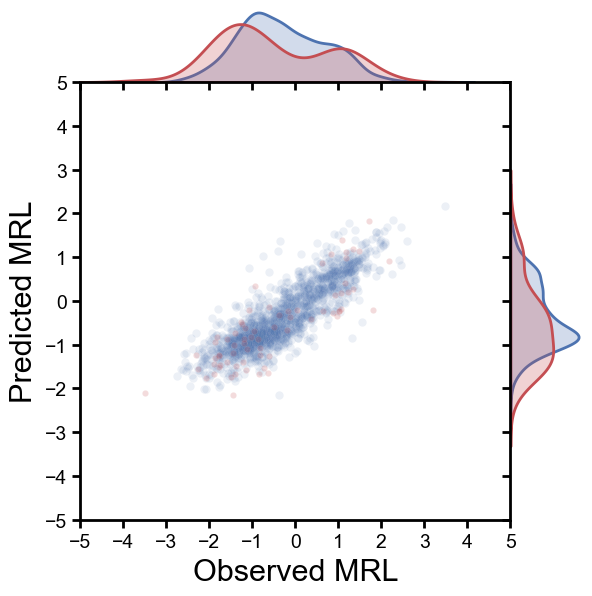

In [10]:
atg = e_test[e_test['seq'].apply(lambda x: 'ATG' in x)]
n_atg = e_test[e_test['seq'].apply(lambda x: 'ATG' not in x)]
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='score', y="pred", data=atg, space=0, ratio=6)
g.plot_joint(plt.scatter,color=c1, linewidth=0.2, alpha=0.1, edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(-5,5.01, 1));
# ax.set_yticklabels(range(-5,5),size=10);
ax.set_xticks(np.arange(-5,5.01, 1));
# ax.set_xticklabels(range(1,5),size=10);
ax.set_ylim(-5,5)
ax.set_xlim(-5,5)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

g.x = n_atg['score'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=0.2, color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig

In [9]:
df.shape

(10892, 8)